In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib
import matplotlib.dates as mdates
from scipy.stats import linregress


In [2]:
df=pd.read_csv("C:\\Users\\ghosh\\OneDrive\\Desktop\\New folder\\Extracted_file.csv")
print(df.columns)

Index(['timestamp', 'Active_Energy_Delivered_Received',
       'Current_Phase_Average', 'Active_Power', 'Performance_Ratio',
       'Wind_Speed', 'Weather_Temperature_Celsius',
       'Weather_Relative_Humidity', 'Global_Horizontal_Radiation',
       'Diffuse_Horizontal_Radiation', 'Wind_Direction',
       'Weather_Daily_Rainfall', 'Radiation_Global_Tilted',
       'Radiation_Diffuse_Tilted'],
      dtype='object')


In [3]:
from datetime import datetime, timedelta
from timezonefinder import TimezoneFinder
from pvlib.location import Location

lat = -23.6980
lon = 133.8807 
location = Location(latitude=lat, longitude=lon)
tf = TimezoneFinder()
tz=tf.certain_timezone_at(lat=lat, lng=lon)

loc = pvlib.location.Location(lat, lon, tz)

df.index = pd.to_datetime(df['timestamp']) #setting Time column of data as the index column
df.index = df.index.tz_localize(tz) #adding the Universal Time Zone (UTZ) to the index column

sun = loc.get_solarposition(df.index) #finding zenith and azimuth
#sun.to_csv('C:\\Users\\ghosh\\OneDrive\\Desktop\\New folder\\Solar_Position.csv')
df2=pd.read_csv('C:\\Users\\ghosh\\OneDrive\\Desktop\\New folder\\Solar_Position.csv')
print(df2.columns)

Index(['timestamp', 'apparent_zenith', 'zenith', 'apparent_elevation',
       'elevation', 'azimuth', 'equation_of_time'],
      dtype='object')


In [4]:
df = pd.merge(df, sun, left_index=True, right_index=True)


In [5]:
tilt=20
azimuth=0
def erbs():
    df2 = pvlib.irradiance.erbs(df['Global_Horizontal_Radiation'], df['zenith'], df.index)

    df['poa-beam'] = pvlib.irradiance.beam_component(tilt, azimuth, df['zenith'], df['azimuth'], df2['dni'])
    df['poa-diff'] = pvlib.irradiance.get_sky_diffuse(tilt, azimuth, df['zenith'], df['azimuth'], df2['dni'], df['Global_Horizontal_Radiation'], df['Diffuse_Horizontal_Radiation'])
    df['POA'] = df['poa-beam'] + df['poa-diff']

In [6]:
erbs()
df['KM'] = pvlib.temperature.sapm_module(df['POA'], df['Weather_Temperature_Celsius'], df['Wind_Speed'], -3.56, -0.075)
df['timestamp'] = pd.to_datetime(df['timestamp'])
#df.set_index('timestamp', inplace=True)

df['m'] = df['timestamp'].dt.month
df['d'] = df['timestamp'].dt.day
df['h'] = df['timestamp'].dt.hour
df['y'] = df['timestamp'].dt.year

s1 = df[(df['m'] == 1) & (df['d'] == 1)]
#Tm=E×exp(a+b×WS)+Ta for King's model

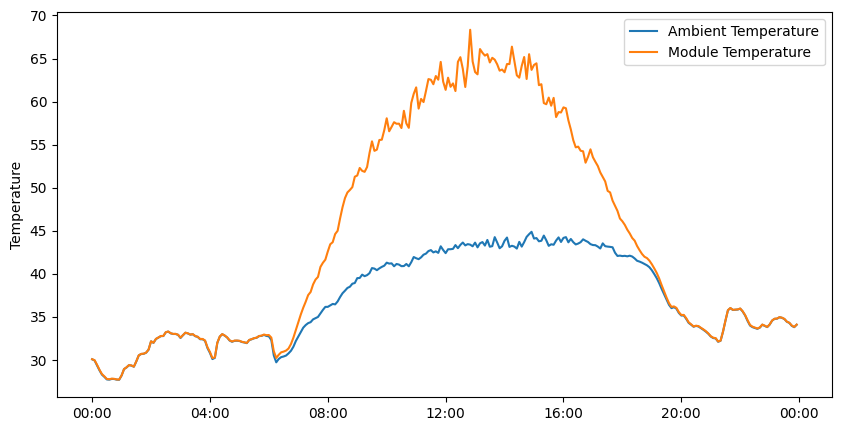

In [7]:
#Tm vs Ta
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(s1['timestamp'], s1['Weather_Temperature_Celsius'], label="Ambient Temperature")
ax.plot(s1['timestamp'], s1['KM'], label="Module Temperature")
ax.set_ylabel("Temperature")
ax.legend()

ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

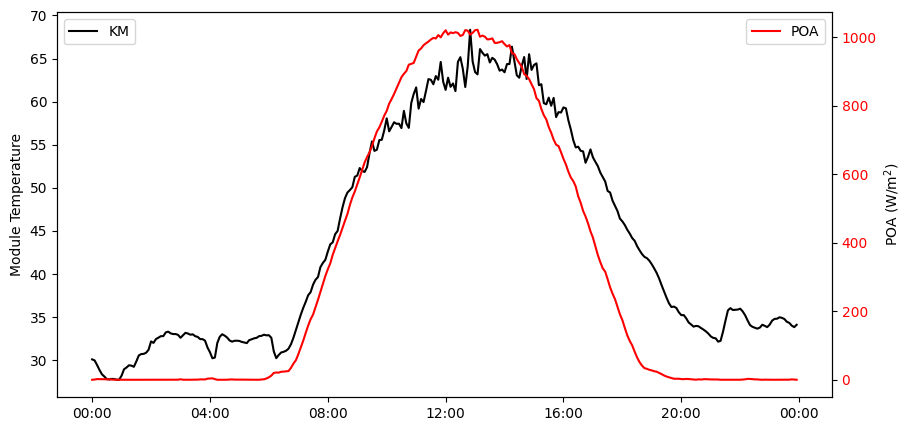

In [8]:
#Tm vs E
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(s1['timestamp'], s1['KM'], label='KM', color='black')
ax.set_ylabel('Module Temperature')
ax.legend(loc='upper left')

ax_2 = ax.twinx()
ax_2.plot(s1['timestamp'], s1['POA'], color='red', label='POA')
ax_2.set_ylabel('POA (W/m$^2$)')
ax_2.tick_params(axis='y', labelcolor='red')


ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks()
ax_2.legend()

plt.show()


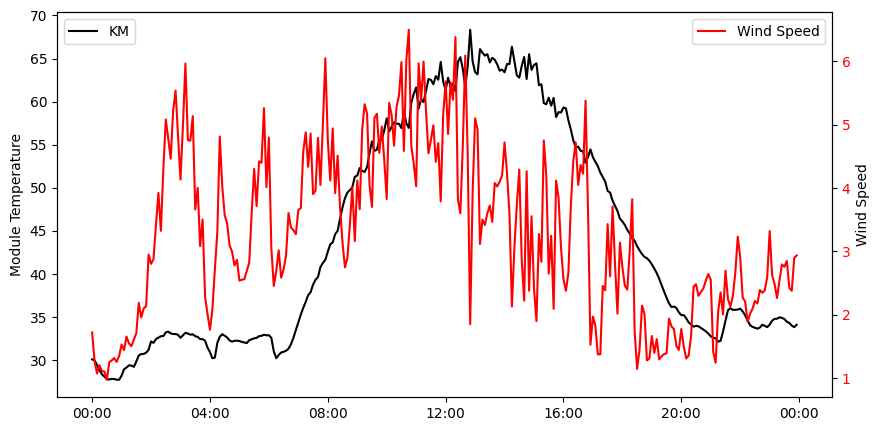

In [9]:
#Tm vs WS@10(?)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(s1['timestamp'], s1['KM'], label='KM', color='black')
ax.set_ylabel('Module Temperature')
ax.legend(loc='upper left')

ax_2 = ax.twinx()
ax_2.plot(s1['timestamp'], s1['Wind_Speed'], color='red', label='Wind Speed')
ax_2.set_ylabel('Wind Speed')
ax_2.tick_params(axis='y', labelcolor='red')


ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax_2.legend()

plt.show()

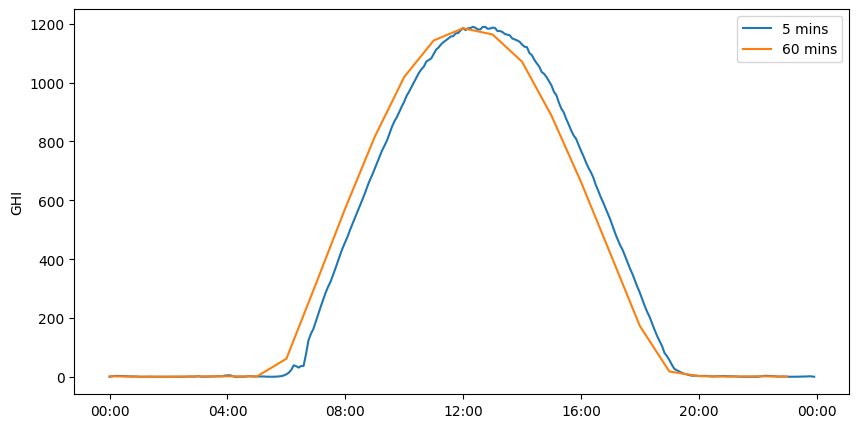

In [10]:
#5min resolution vs 60 min resolution
df.index = pd.to_datetime(df['timestamp'])
s2 = pd.DataFrame(df.resample('h').mean())
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index[(df['m'] == 1) & (df['d'] == 1)& (df['y']==2014)], df['Global_Horizontal_Radiation'][(df['m'] == 1) & (df['d'] == 1)], label='5 mins')
ax.plot(s2.index[(s2['m'] == 1) & (s2['d'] == 1) & (s2['y']==2014)], s2['Global_Horizontal_Radiation'][(s2['m'] == 1) & (s2['d'] == 1)], label='60 mins')
ax.set_ylabel('GHI')

ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.legend()
plt.show()

In [11]:
#Pdc=Gpoaeff*Pdc0(1+γpdc(Tcell−Tref))/1000
#Pdc0=215 W rated total=5.805kW
#Tcell=temperature from King's model
df['DC'] =(pvlib.pvsystem.pvwatts_dc(df['POA'], df['KM'], 5.805, -0.005, 25))

Text(0, 0.5, 'Power')

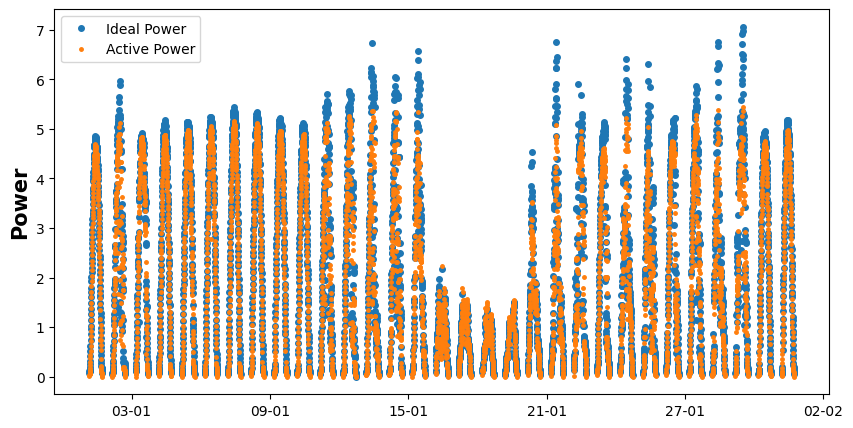

In [12]:
s = pd.DataFrame(df[(df['y']==2014) & (df['m']==1)])
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(s['timestamp'][s['Active_Power']>0], s['DC'][s['Active_Power']>0], 'o', markersize=4, label='Ideal Power')
ax.plot(s['timestamp'][s['Active_Power']>0], s['Active_Power'][s['Active_Power']>0], 'o', markersize=2.5, label='Active Power')
ax.xaxis.set_major_locator(mdates.HourLocator(interval=144))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))  
ax.legend()
ax.set_ylabel('Power', weight='bold', fontsize=15)



Text(0, 0.5, 'Instantaneous PV PR')

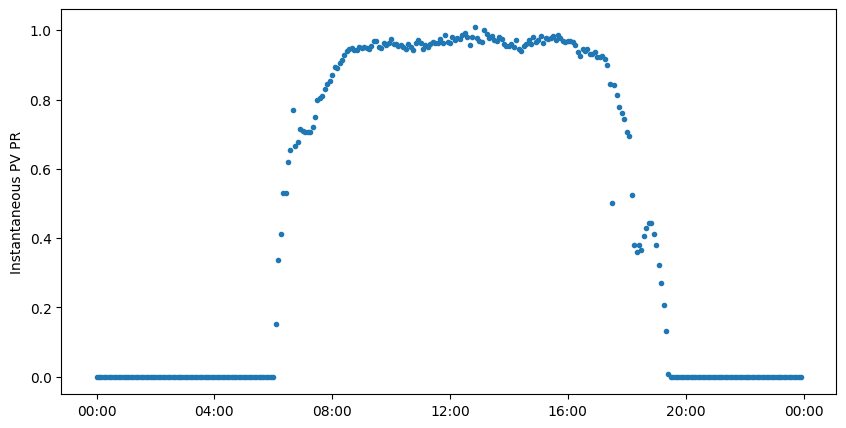

In [13]:
df['PR'] = df['Active_Power']/df['DC']
fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index[(df['y']==2014) & (df['m']==1) & (df['d']==1)], df['PR'][(df['y']==2014) & (df['m']==1) & (df['d']==1)],'o', markersize=3)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylabel('Instantaneous PV PR')

In [14]:
print('Mean PR:', np.mean(df['PR'][(df['y']==2014) & (df['m']==1) & (df['d']==1) & (df['h']>=10) & (df['h']<=14)]))
print('Median PR:', np.median(df['PR'][(df['y']==2014) & (df['m']==1) & (df['d']==1) & (df['h']>=10) & (df['h']<=14)]))
scaler=np.median(df['PR'][(df['y']==2014) & (df['m']==1) & (df['d']==1) & (df['h']>=10) & (df['h']<=14)])

Mean PR: 0.9667979334300181
Median PR: 0.9652038764674997


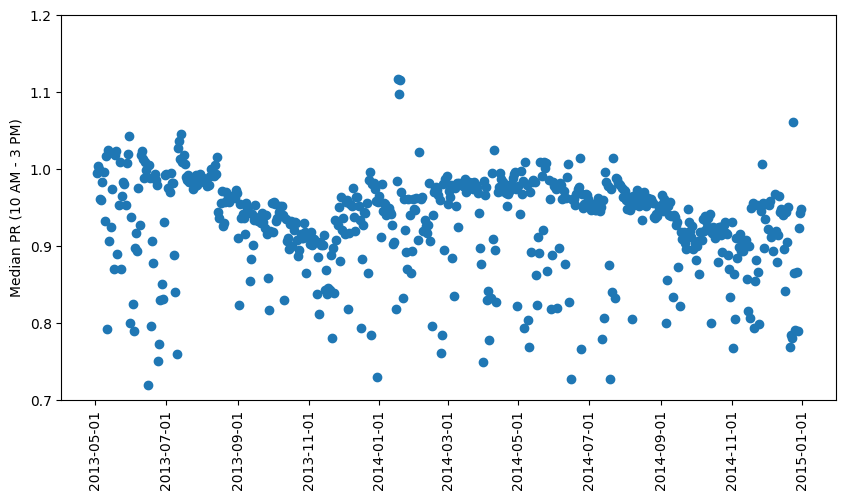

In [15]:
filtered_data = df[(df.index.hour >= 10) & (df.index.hour <= 14)]
median_pr = filtered_data.groupby(filtered_data.index.date)['PR'].median()
median_pr = median_pr[(median_pr <= 1.5) & (median_pr > 0) & median_pr.notna()]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(median_pr.index, median_pr.values, 'o')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Median PR (10 AM - 3 PM)')
plt.xticks(rotation=90)
ax.set_ylim(0.7, 1.2) 
plt.show()





In [16]:
def modified_hampel_filter(data, window_size=7, n_sigma=1):
    filtered_data = data.copy()
    k=1.4826
    n=len(data)
    for i in range((window_size),(n - window_size)):
        x0 = np.median(data[(i - window_size):i])
        S0 = k * np.median(np.abs(data[(i - window_size):i] - x0))
        if (np.abs(data[i] - x0) > n_sigma * S0):
            filtered_data[i] = np.nan
    filtered_data.ffill(inplace=True)

    return filtered_data


C:\Users\ghosh\AppData\Local\Temp\ipykernel_36392\1619417340.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (np.abs(data[i] - x0) > n_sigma * S0):
C:\Users\ghosh\AppData\Local\Temp\ipykernel_36392\1619417340.py:9: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  filtered_data[i] = np.nan


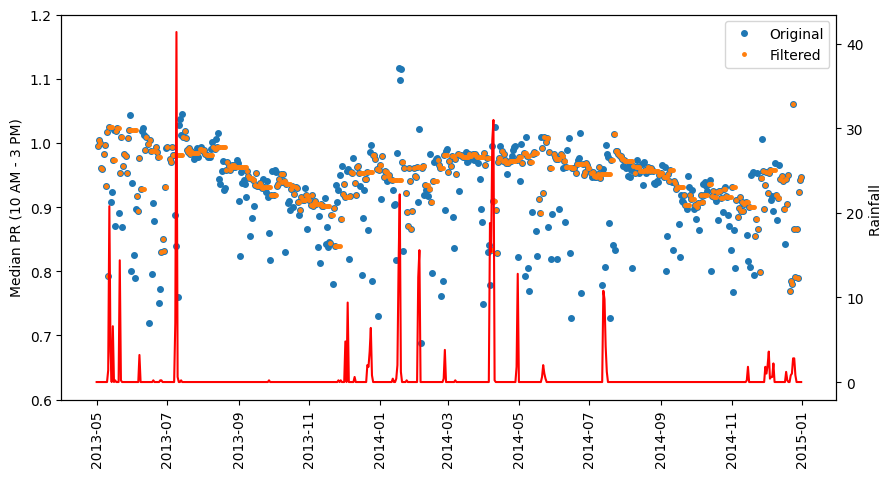

In [17]:
hampel_pr = modified_hampel_filter(median_pr,11,1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(median_pr.index, median_pr.values,'o', label='Original',markersize=4)
ax.plot(hampel_pr.index, hampel_pr.values,'o', label='Filtered',markersize=2.5)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_ylabel('Median PR (10 AM - 3 PM)')
plt.xticks(rotation=90)
ax2 = ax.twinx()
daily_max_rainfall = df.resample('D')['Weather_Daily_Rainfall'].max()
ax2.plot(daily_max_rainfall.index, daily_max_rainfall.values, label='Daily Max Rainfall', color='red')
ax2.set_ylabel('Rainfall ')

ax.set_ylim(0.6, 1.2) 
ax.legend(loc='upper right')


plt.show()

In [18]:
from scipy.stats import iqr
def detect_cleaning_events(series, window=7, alpha=1.5):
    rolling_median = series.rolling(window=window, center=True).median()
    differences = rolling_median.diff().dropna()
    Q3 = differences.quantile(0.75)
    IQR = iqr(differences)
    threshold = Q3 + alpha * IQR
    cleaning_events = differences[differences > threshold]
    return cleaning_events.index

In [19]:
cleaning_events = detect_cleaning_events(hampel_pr,6,6)
print(list(cleaning_events)[:5])


[datetime.date(2013, 5, 10), datetime.date(2013, 5, 11), datetime.date(2013, 5, 12), datetime.date(2013, 5, 20), datetime.date(2013, 5, 28)]


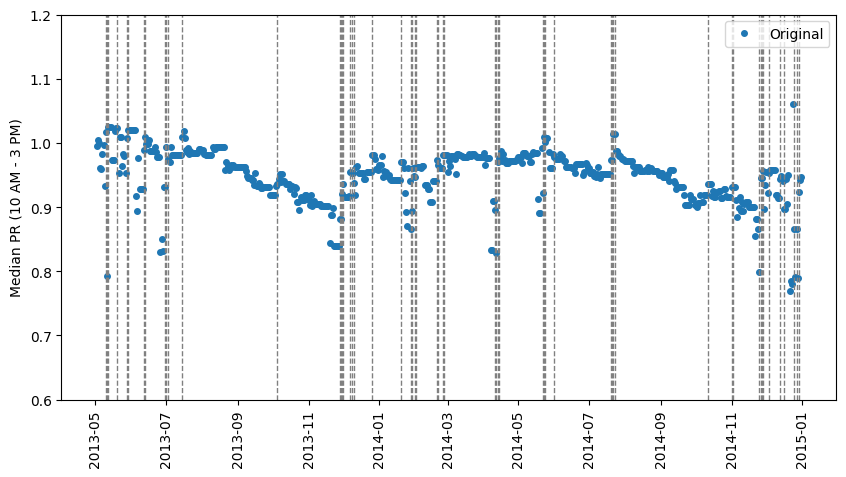

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hampel_pr.index, hampel_pr.values, 'o', label='Original', markersize=4)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=90)
ax.set_ylabel('Median PR (10 AM - 3 PM)')
ax.set_ylim(0.6, 1.2)
ax.legend(loc='upper right')


for event in cleaning_events:
    ax.axvline(x=event, color='gray', linestyle='--', linewidth=1)


14:56:27 - cmdstanpy - INFO - Chain [1] start processing
14:56:27 - cmdstanpy - INFO - Chain [1] done processing


Start: 2013-06-14, End: 2013-06-29
-0.025913511157965585


14:56:27 - cmdstanpy - INFO - Chain [1] start processing
14:56:28 - cmdstanpy - INFO - Chain [1] done processing
14:56:28 - cmdstanpy - INFO - Chain [1] start processing


Start: 2013-07-16, End: 2013-10-04
-0.0013212658412873242


14:56:29 - cmdstanpy - INFO - Chain [1] done processing


Start: 2013-10-06, End: 2013-11-27
-0.003734587666300755


14:56:29 - cmdstanpy - INFO - Chain [1] start processing
14:56:29 - cmdstanpy - INFO - Chain [1] done processing
14:56:30 - cmdstanpy - INFO - Chain [1] start processing


Start: 2013-12-27, End: 2014-01-19
-0.006949134349655106


14:56:30 - cmdstanpy - INFO - Chain [1] done processing


Start: 2014-02-03, End: 2014-02-19
-0.007652153172177339


14:56:30 - cmdstanpy - INFO - Chain [1] start processing
14:56:30 - cmdstanpy - INFO - Chain [1] done processing


Start: 2014-02-27, End: 2014-04-10
-0.003891730147207936


14:56:31 - cmdstanpy - INFO - Chain [1] start processing
14:56:31 - cmdstanpy - INFO - Chain [1] done processing
14:56:31 - cmdstanpy - INFO - Chain [1] start processing


Start: 2014-04-15, End: 2014-05-21
0.0010935861019416022


14:56:32 - cmdstanpy - INFO - Chain [1] done processing
14:56:32 - cmdstanpy - INFO - Chain [1] start processing


Start: 2014-06-02, End: 2014-07-19
-0.0010167743222580863


14:56:33 - cmdstanpy - INFO - Chain [1] done processing
14:56:33 - cmdstanpy - INFO - Chain [1] start processing


Start: 2014-07-24, End: 2014-10-11
-0.0010774226705390182


14:56:33 - cmdstanpy - INFO - Chain [1] done processing
14:56:33 - cmdstanpy - INFO - Chain [1] start processing


Start: 2014-10-13, End: 2014-10-31
-0.005602952648799024


14:56:33 - cmdstanpy - INFO - Chain [1] done processing


Start: 2014-11-03, End: 2014-11-24
-0.013363089814446128


14:56:34 - cmdstanpy - INFO - Chain [1] start processing
14:56:34 - cmdstanpy - INFO - Chain [1] done processing
14:56:34 - cmdstanpy - INFO - Chain [1] start processing
14:56:35 - cmdstanpy - INFO - Chain [1] done processing
14:56:35 - cmdstanpy - INFO - Chain [1] start processing
14:56:35 - cmdstanpy - INFO - Chain [1] done processing
14:56:35 - cmdstanpy - INFO - Chain [1] start processing
14:56:36 - cmdstanpy - INFO - Chain [1] done processing
14:56:36 - cmdstanpy - INFO - Chain [1] start processing
14:56:36 - cmdstanpy - INFO - Chain [1] done processing
14:56:36 - cmdstanpy - INFO - Chain [1] start processing
14:56:37 - cmdstanpy - INFO - Chain [1] done processing
14:56:37 - cmdstanpy - INFO - Chain [1] start processing
14:56:37 - cmdstanpy - INFO - Chain [1] done processing
14:56:37 - cmdstanpy - INFO - Chain [1] start processing
14:56:38 - cmdstanpy - INFO - Chain [1] done processing
14:56:38 - cmdstanpy - INFO - Chain [1] start processing
14:56:38 - cmdstanpy - INFO - Chain [1]

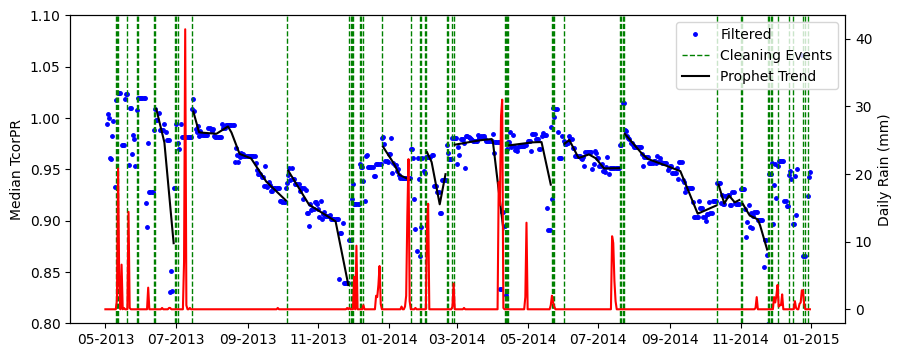

In [21]:
from prophet import Prophet

def fbp(D, y):
    ts = pd.DataFrame({'ds': D, 'y': y})
    ts = ts.dropna()
    
    prophet = Prophet()
    prophet.fit(ts)
    future = prophet.make_future_dataframe(periods=0)
    forecast = prophet.predict(future)
    
    return forecast['trend']

sublist_collection = []
start_dates_before=[]
end_dates_before=[]
soiling_before=[]
for i in range(1, len(cleaning_events)):
    start = cleaning_events[i - 1] + timedelta(days=1)
    end = cleaning_events[i] - timedelta(days=1)
    
    if (end - start).days >= 15:
        sub_df = hampel_pr[(hampel_pr.index >= start) & (hampel_pr.index <= end)]
        sublist_collection.append(sub_df)
        
        if len(sub_df) >= 15:
            trend = fbp(sub_df.index, sub_df.values)
            
            slopes = sub_df.diff().dropna()
            weights = len(sub_df)
            total_weighted_slope =100* (slopes .sum()) / weights
            start_dates_before.append(start)
            end_dates_before.append(end)
            soiling_before.append(total_weighted_slope)
            print(f"Start: {start}, End: {end}")
            print(total_weighted_slope/weights)

# Plotting code remains unchanged
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(hampel_pr.index, hampel_pr.values, 'o', color='blue', label='Filtered', markersize=2.5)

for event in cleaning_events:
    ax.axvline(x=event, color='green', linestyle='--', linewidth=1, label='Cleaning Events' if event == cleaning_events[0] else "")

for sublist in sublist_collection:
    trend = fbp(sublist.index, sublist.values)
    ax.plot(sublist.index, trend, color='black', label='Prophet Trend' if sublist is sublist_collection[0] else "")

ax2 = ax.twinx()
daily_max_rainfall = df.resample('D')['Weather_Daily_Rainfall'].max()
ax2.plot(daily_max_rainfall.index, daily_max_rainfall.values, color='red', label='Rainfall')
ax2.set_ylabel('Daily Rain (mm)')
#ax2.set_ylim(0, 70)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.set_ylabel('Median TcorPR')
plt.xticks(rotation=90)
ax.set_ylim(0.8, 1.1)
ax.legend(loc='upper right')

plt.show()


14:56:40 - cmdstanpy - INFO - Chain [1] start processing
14:56:40 - cmdstanpy - INFO - Chain [1] done processing
14:56:41 - cmdstanpy - INFO - Chain [1] start processing
14:56:41 - cmdstanpy - INFO - Chain [1] done processing
14:56:42 - cmdstanpy - INFO - Chain [1] start processing
14:56:42 - cmdstanpy - INFO - Chain [1] done processing
14:56:42 - cmdstanpy - INFO - Chain [1] start processing
14:56:42 - cmdstanpy - INFO - Chain [1] done processing
14:56:43 - cmdstanpy - INFO - Chain [1] start processing
14:56:43 - cmdstanpy - INFO - Chain [1] done processing
14:56:43 - cmdstanpy - INFO - Chain [1] start processing
14:56:43 - cmdstanpy - INFO - Chain [1] done processing
14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] done processing
14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] done processing
14:56:45 - cmdstanpy - INFO - Chain [1] start processing
14:56:45 - cmdstanpy - INFO - Chain [1]

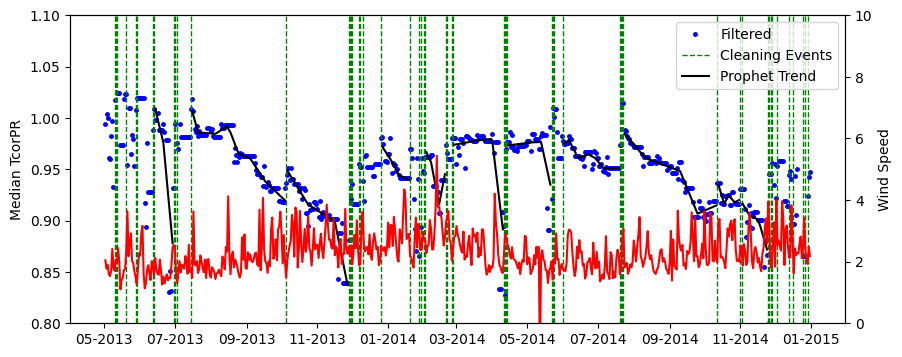

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(hampel_pr.index, hampel_pr.values, 'o', color='blue', label='Filtered', markersize=2.5)

for event in cleaning_events:
    ax.axvline(x=event, color='green', linestyle='--', linewidth=1, label='Cleaning Events' if event == cleaning_events[0] else "")

for sublist in sublist_collection:
    trend = fbp(sublist.index, sublist.values)
    ax.plot(sublist.index, trend, color='black', label='Prophet Trend' if sublist is sublist_collection[0] else "")

ax2 = ax.twinx()
ws1 = df.between_time('00:00', '23:55').resample('D')['Wind_Speed'].mean()
ax2.plot(ws1.index, ws1.values, color='red', label='Wind Speed')
ax2.set_ylabel('Wind Speed')
ax2.set_ylim(0,10)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.set_ylabel('Median TcorPR')
plt.xticks(rotation=90)
ax.set_ylim(0.8, 1.1)
ax.legend(loc='upper right')

plt.show()

14:56:48 - cmdstanpy - INFO - Chain [1] start processing
14:56:48 - cmdstanpy - INFO - Chain [1] done processing
14:56:48 - cmdstanpy - INFO - Chain [1] start processing
14:56:48 - cmdstanpy - INFO - Chain [1] done processing
14:56:49 - cmdstanpy - INFO - Chain [1] start processing
14:56:49 - cmdstanpy - INFO - Chain [1] done processing
14:56:49 - cmdstanpy - INFO - Chain [1] start processing
14:56:50 - cmdstanpy - INFO - Chain [1] done processing
14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:50 - cmdstanpy - INFO - Chain [1] done processing
14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:51 - cmdstanpy - INFO - Chain [1] done processing
14:56:51 - cmdstanpy - INFO - Chain [1] start processing
14:56:51 - cmdstanpy - INFO - Chain [1] done processing
14:56:51 - cmdstanpy - INFO - Chain [1] start processing
14:56:52 - cmdstanpy - INFO - Chain [1] done processing
14:56:52 - cmdstanpy - INFO - Chain [1] start processing
14:56:52 - cmdstanpy - INFO - Chain [1]

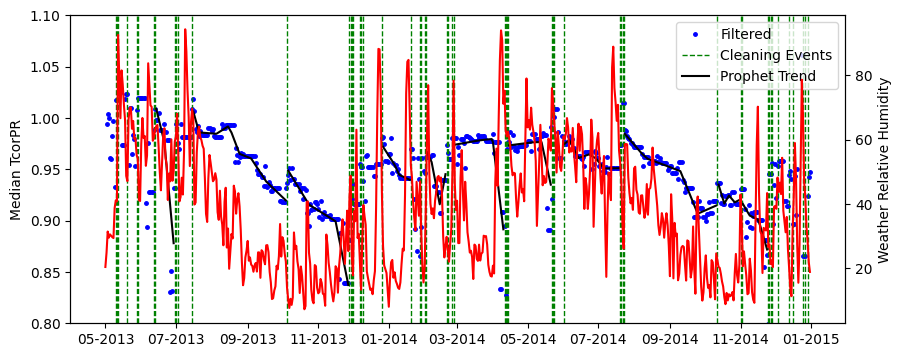

In [23]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(hampel_pr.index, hampel_pr.values, 'o', color='blue', label='Filtered', markersize=2.5)

for event in cleaning_events:
    ax.axvline(x=event, color='green', linestyle='--', linewidth=1, label='Cleaning Events' if event == cleaning_events[0] else "")

for sublist in sublist_collection:
    trend = fbp(sublist.index, sublist.values)
    ax.plot(sublist.index, trend, color='black', label='Prophet Trend' if sublist is sublist_collection[0] else "")

ax2 = ax.twinx()
ws = df.between_time('00:00', '23:55').resample('D')['Weather_Relative_Humidity'].mean()
ax2.plot(ws.index, ws.values, color='red', label='Weather Relative Humidity')
ax2.set_ylabel('Weather Relative Humidity')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.set_ylabel('Median TcorPR')
plt.xticks(rotation=90)
ax.set_ylim(0.8, 1.1)
ax.legend(loc='upper right')

plt.show()

In [24]:
df['EW']=  (243.04 * (np.log(df['Weather_Relative_Humidity']/100) + (17.625 * df['Weather_Temperature_Celsius'])/(243.04 + df['Weather_Temperature_Celsius']))) / (17.625 - np.log(df['Weather_Relative_Humidity']/100) - (17.625 * df['Weather_Temperature_Celsius'])/(243.04 + df['Weather_Temperature_Celsius']))

14:56:55 - cmdstanpy - INFO - Chain [1] start processing
14:56:55 - cmdstanpy - INFO - Chain [1] done processing
14:56:55 - cmdstanpy - INFO - Chain [1] start processing
14:56:55 - cmdstanpy - INFO - Chain [1] done processing
14:56:56 - cmdstanpy - INFO - Chain [1] start processing
14:56:56 - cmdstanpy - INFO - Chain [1] done processing
14:56:56 - cmdstanpy - INFO - Chain [1] start processing
14:56:56 - cmdstanpy - INFO - Chain [1] done processing
14:56:57 - cmdstanpy - INFO - Chain [1] start processing
14:56:57 - cmdstanpy - INFO - Chain [1] done processing
14:56:57 - cmdstanpy - INFO - Chain [1] start processing
14:56:57 - cmdstanpy - INFO - Chain [1] done processing
14:56:58 - cmdstanpy - INFO - Chain [1] start processing
14:56:58 - cmdstanpy - INFO - Chain [1] done processing
14:56:58 - cmdstanpy - INFO - Chain [1] start processing
14:56:58 - cmdstanpy - INFO - Chain [1] done processing
14:56:59 - cmdstanpy - INFO - Chain [1] start processing
14:56:59 - cmdstanpy - INFO - Chain [1]

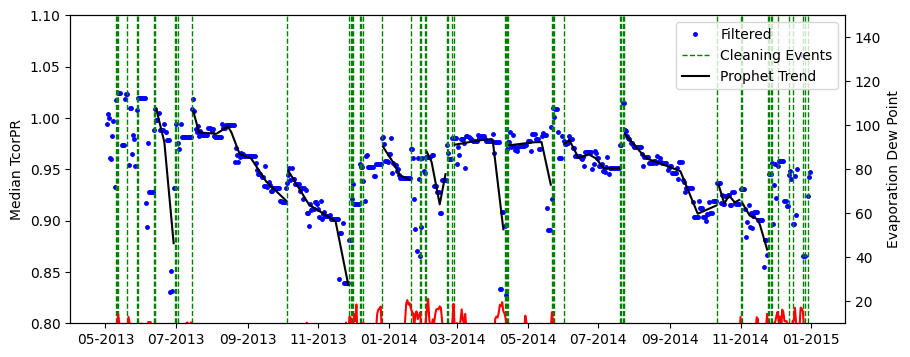

In [25]:

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(hampel_pr.index, hampel_pr.values, 'o', color='blue', label='Filtered', markersize=2.5)

for event in cleaning_events:
    ax.axvline(x=event, color='green', linestyle='--', linewidth=1, label='Cleaning Events' if event == cleaning_events[0] else "")

for sublist in sublist_collection:
    trend = fbp(sublist.index, sublist.values)
    ax.plot(sublist.index, trend, color='black', label='Prophet Trend' if sublist is sublist_collection[0] else "")

ax2 = ax.twinx()
ws = df.between_time('10:00', '15:00').resample('D')['EW'].mean()
ax2.plot(ws.index, ws.values, color='red', label='Evaporation Dew Point')
ax2.set_ylabel('Evaporation Dew Point')
ax2.set_ylim(10,150)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.set_ylabel('Median TcorPR')
plt.xticks(rotation=90)
ax.set_ylim(0.8, 1.1)
ax.legend(loc='upper right')

plt.show()

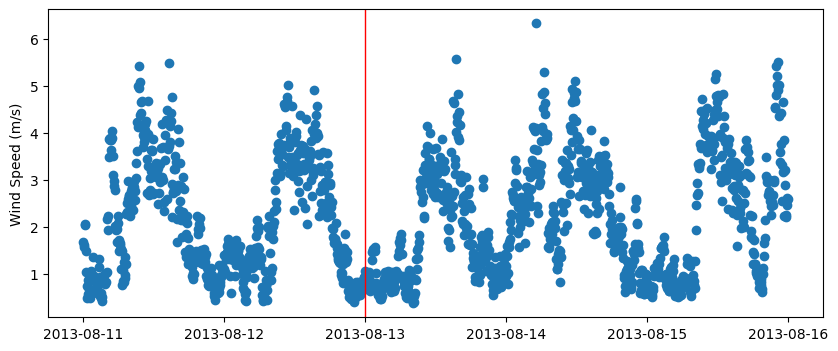

In [26]:
ws_subset = df['Wind_Speed']['2013-08-11':'2013-08-15']
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ws_subset.index, ws_subset.values,'o', label='Wind Speed')
ax.axvline(x=pd.to_datetime('2013-08-13'), color='red', linestyle='-', linewidth=1, label='Vertical Line on 2013-08-13')

ax.set_ylabel('Wind Speed (m/s)') 
plt.show()

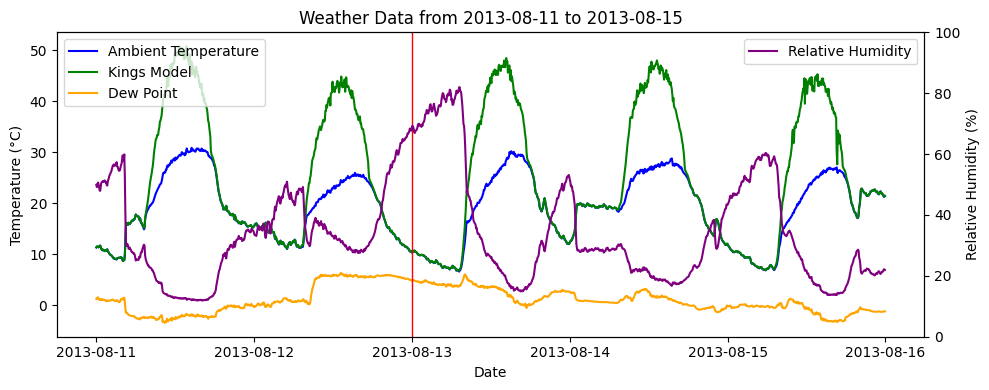

In [27]:


# Extract the required data for the specified date range

temp_subset = df['Weather_Temperature_Celsius']['2013-08-11':'2013-08-15']
kings_model_subset = df['KM']['2013-08-11':'2013-08-15']
dew_point_subset = df['EW']['2013-08-11':'2013-08-15']
humidity_subset = df['Weather_Relative_Humidity']['2013-08-11':'2013-08-15']

# Create a new figure and axis for the plot
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot the ambient temperature, King's model, and dew point on the left y-axis
ax1.plot(temp_subset.index, temp_subset.values, label='Ambient Temperature', color='blue')
ax1.plot(kings_model_subset.index, kings_model_subset.values, label='Kings Model', color='green')
ax1.plot(dew_point_subset.index, dew_point_subset.values, label='Dew Point', color='orange')

# Adding labels and legend for the left y-axis
ax1.set_ylabel('Temperature (°C)')
ax1.set_xlabel('Date')
ax1.legend(loc='upper left')

# Adding a vertical line on '2013-08-13'
ax1.axvline(x=pd.to_datetime('2013-08-13'), color='red', linestyle='-', linewidth=1, label='Vertical Line on 2013-08-13')

# Formatting x-axis dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


# Create a second y-axis for relative humidity
ax2 = ax1.twinx()
ax2.plot(humidity_subset.index, humidity_subset.values, label='Relative Humidity', color='purple')
ax2.set_ylabel('Relative Humidity (%)')
ax2.set_ylim(0, 100)

# Adding labels and legend for the right y-axis
ax2.legend(loc='upper right')

# Adding a title
plt.title('Weather Data from 2013-08-11 to 2013-08-15')

# Show the plot
plt.tight_layout()
plt.show()


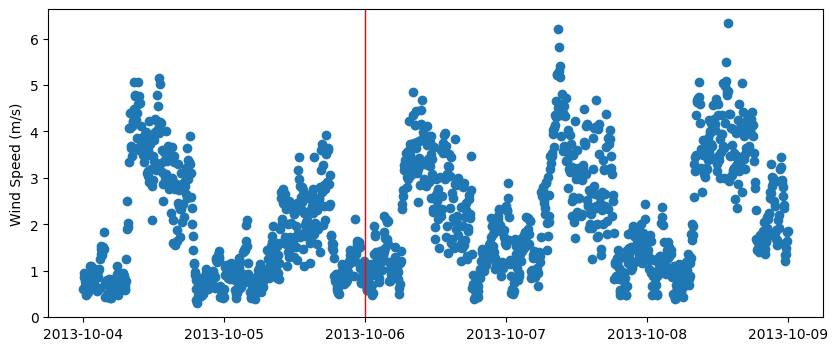

In [28]:
ws_subset = df['Wind_Speed']['2013-10-04':'2013-10-08']
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ws_subset.index, ws_subset.values,'o', label='Wind Speed')
ax.axvline(x=pd.to_datetime('2013-10-06'), color='red', linestyle='-', linewidth=1, label='Vertical Line on 2013-08-13')

ax.set_ylabel('Wind Speed (m/s)') 
plt.show()

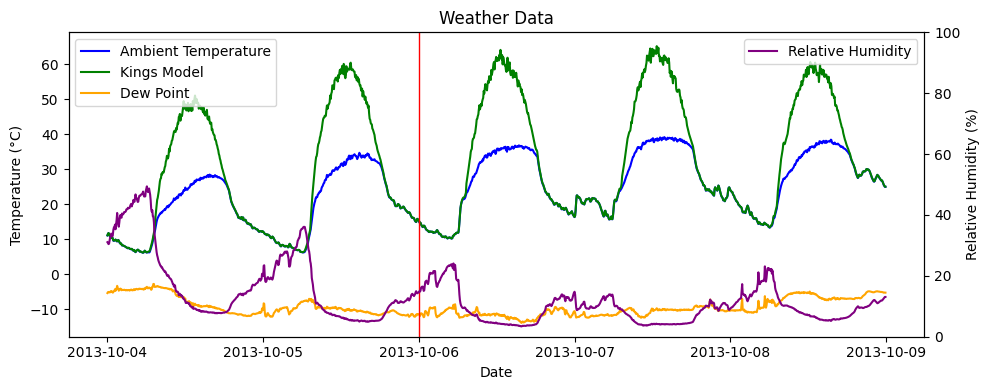

In [29]:


# Extract the required data for the specified date range

temp_subset = df['Weather_Temperature_Celsius']['2013-10-04':'2013-10-08']
kings_model_subset = df['KM']['2013-10-04':'2013-10-08']
dew_point_subset = df['EW']['2013-10-04':'2013-10-08']
humidity_subset = df['Weather_Relative_Humidity']['2013-10-04':'2013-10-08']

# Create a new figure and axis for the plot
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot the ambient temperature, King's model, and dew point on the left y-axis
ax1.plot(temp_subset.index, temp_subset.values, label='Ambient Temperature', color='blue')
ax1.plot(kings_model_subset.index, kings_model_subset.values, label='Kings Model', color='green')
ax1.plot(dew_point_subset.index, dew_point_subset.values, label='Dew Point', color='orange')

# Adding labels and legend for the left y-axis
ax1.set_ylabel('Temperature (°C)')
ax1.set_xlabel('Date')
ax1.legend(loc='upper left')

# Adding a vertical line on '2013-08-13'
ax1.axvline(x=pd.to_datetime('2013-10-06'), color='red', linestyle='-', linewidth=1)

# Formatting x-axis dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


# Create a second y-axis for relative humidity
ax2 = ax1.twinx()
ax2.plot(humidity_subset.index, humidity_subset.values, label='Relative Humidity', color='purple')
ax2.set_ylabel('Relative Humidity (%)')
ax2.set_ylim(0, 100)

# Adding labels and legend for the right y-axis
ax2.legend(loc='upper right')

# Adding a title
plt.title('Weather Data')

# Show the plot
plt.tight_layout()
plt.show()


In [30]:
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

df3 = pd.read_csv('C:\\Users\\ghosh\\OneDrive\\Desktop\\New folder\\Median.csv')

df3['date'] = pd.to_datetime(df3['Unnamed: 0'])
df3.set_index('date', inplace=True)
df3.drop(columns=['Unnamed: 0'], inplace=True)

med = pd.Series(df3['PR'].values, index=df3.index)


In [31]:
n = len(med)
freq = (1 / n) * np.arange(n)

L = np.arange(1, np.floor(n / 2), dtype='int')
fft_pr_ = np.fft.fft(med.values, n)
PSD_pr = np.abs(fft_pr_)


In [32]:
hover = HoverTool(
    tooltips=[
        ('x', '$x'),
        ('y', '$y'),
        ('name', '$name')
    ]
)
p2 = figure(title=None, height=500)
p2.line(freq[L], np.real(PSD_pr[L]), color='red')
p2.circle(freq[L], np.real(PSD_pr[L]), color='red', legend_label='FFT PR', size=8)

p2.add_tools(hover)
p2.legend.location = "top_right"
p2.xaxis.axis_label = "Frequency (1/day)"
p2.xaxis.axis_label_text_font_size = "11pt"
p2.xaxis.major_label_text_font_size = "9pt"

p2.yaxis.axis_label = "Power Spectral Density (PSD)"
p2.yaxis.axis_label_text_font_size = "11pt"
p2.yaxis.major_label_text_font_size = "9pt"

show(p2)


In [33]:
max_psd_index = np.argmax(PSD_pr[L])
max_psd_freq = freq[L][max_psd_index]
print(f"Frequency corresponding to maximum PSD: {max_psd_freq}")


Frequency corresponding to maximum PSD: 0.003289473684210526


In [34]:
threshold = 1 / 365

freq[freq < threshold] = threshold

freq[np.argmax(PSD_pr)] = threshold
#freq=freq*max_psd_freq/365.0


In [35]:
indicies_pr_2 = (PSD_pr > 4)
indicies_pr_all = (PSD_pr < 4)

PSD_pr_clean_2 = PSD_pr * indicies_pr_2
PSD_pr_clean_all = PSD_pr * indicies_pr_all
freq_2 = freq * indicies_pr_2
freq_all = freq * indicies_pr_all

fft_pr_clean_2_ = indicies_pr_2 * fft_pr_
fft_pr_clean_all_ = indicies_pr_all * fft_pr_


In [36]:
hover = HoverTool(
    tooltips=[
        ('x', '$x'),
        ('y', '$y'),
        ('name', '$name')
    ]
)

p2 = figure(title='original signal', sizing_mode='stretch_width', height=500)
p2.line(freq[L], np.real(PSD_pr[L]), color='red', legend_label='PSD')
p2.circle(freq[L], np.real(PSD_pr[L]), color='red', legend_label='PSD', size=8)
p2.circle(freq[L], np.real(PSD_pr_clean_2[L]), color='blue', legend_label='seasonal component', size=8)
p2.circle(freq[L], np.real(PSD_pr_clean_all[L]), color='green', legend_label='after elimination of seasonal component', size=8)

p2.add_tools(hover)
p2.legend.click_policy = "hide"

show(p2)

In [37]:
ifft_pr_2 = np.fft.ifft(fft_pr_clean_2_)  # seasonal component
ifft_pr_all = np.fft.ifft(fft_pr_clean_all_)  # after elimination of seasonal component


In [38]:
df3['ifft_pr_freq_seasonal'] = np.real(ifft_pr_2)
df3['ifft_pr_freq_after_seasonal_1'] = df3['PR'] - df3['ifft_pr_freq_seasonal']
df3['ifft_pr_freq_after_seasonal_2'] = np.real(ifft_pr_all)


In [39]:
hover = HoverTool(
    tooltips=[
        ('date', '$x{%Y-%m-%d %H:%M}'),
        ("value", "$y"),
        ('name', '$name'),
    ],
    formatters={'$x': 'datetime', },
)

p2 = figure(title=None, x_axis_type='datetime', height=500)
p2.circle(df3.index, df3['PR'], color='red', legend_label='PR', size=8)
p2.line(df3.index, df3['ifft_pr_freq_seasonal'], color='black', legend_label='Seasonal component of PR', line_width=3)
p2.circle(df3.index, df3['ifft_pr_freq_after_seasonal_1'], color='blue', legend_label='after elimination of seasonal component_n', size=8)
p2.circle(df3.index, df3['ifft_pr_freq_after_seasonal_2'], color='green', legend_label='after elimination of seasonal component_all', size=8)

p2.add_tools(hover)

p2.legend.location = "right"
p2.xaxis.axis_label = "Date (Year)"
p2.xaxis.axis_label_text_font_size = "11pt"
p2.xaxis.major_label_text_font_size = "9pt"

p2.yaxis.axis_label = "Performance ratio"
p2.yaxis.axis_label_text_font_size = "11pt"
p2.yaxis.major_label_text_font_size = "9pt"
p2.legend.click_policy = "hide"

p2.legend.label_text_font_size = '10pt'
p2.legend.glyph_height = 10
p2.legend.glyph_width = 10
p2.legend.spacing = 5
p2.legend.label_standoff = 5

show(p2)


In [40]:

df3['scaled'] = df3['ifft_pr_freq_after_seasonal_2'] 
df3['scaled'] = df3['ifft_pr_freq_after_seasonal_2'].apply(lambda value: value + scaler)


p = figure(title='Modified Data', x_axis_type='datetime', height=400)
p.circle(df3.index, df3['scaled'], color='blue', legend_label='Modified Data', size=8)

p.xaxis.axis_label = "Date (Year)"
p.yaxis.axis_label = "Modified Values"
p.legend.location = "top_left"
p.y_range.start = 0
p.y_range.end = 1.5 

show(p)


In [41]:
data=df3['scaled']

C:\Users\ghosh\AppData\Local\Temp\ipykernel_36392\1619417340.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (np.abs(data[i] - x0) > n_sigma * S0):
C:\Users\ghosh\AppData\Local\Temp\ipykernel_36392\1619417340.py:9: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  filtered_data[i] = np.nan


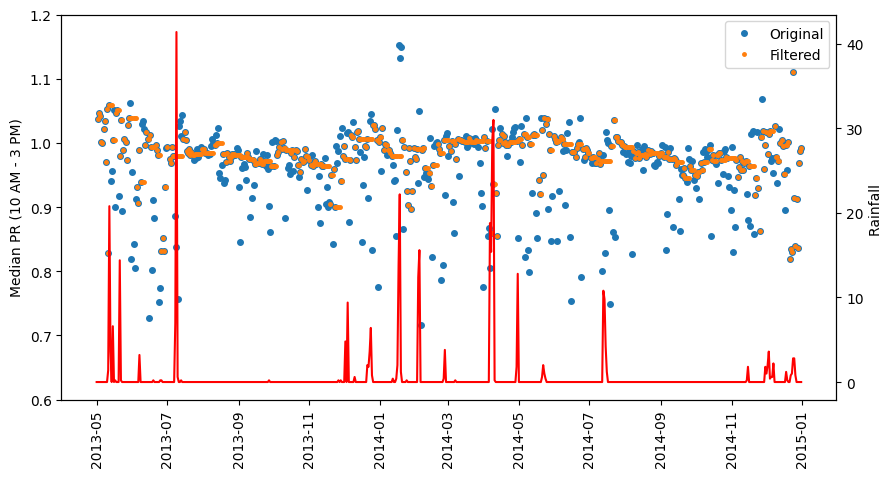

In [42]:
hampel_pr = modified_hampel_filter(data,11,1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(median_pr.index, data.values,'o', label='Original',markersize=4)
ax.plot(hampel_pr.index, hampel_pr.values,'o', label='Filtered',markersize=2.5)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_ylabel('Median PR (10 AM - 3 PM)')
plt.xticks(rotation=90)
ax2 = ax.twinx()
daily_max_rainfall = df.resample('D')['Weather_Daily_Rainfall'].max()
ax2.plot(daily_max_rainfall.index, daily_max_rainfall.values, label='Daily Max Rainfall', color='red')
ax2.set_ylabel('Rainfall ')

ax.set_ylim(0.6, 1.2) 
ax.legend(loc='upper right')


plt.show()

In [43]:
cleaning_events = detect_cleaning_events(hampel_pr,6,6)

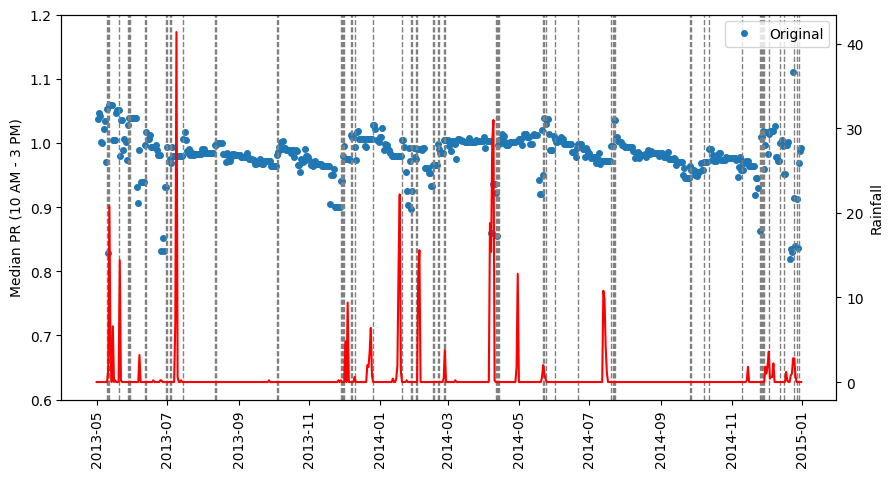

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hampel_pr.index, hampel_pr.values, 'o', label='Original', markersize=4)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=90)
ax.set_ylabel('Median PR (10 AM - 3 PM)')
ax.set_ylim(0.6, 1.2)
ax.legend(loc='upper right')

ax2 = ax.twinx()
daily_max_rainfall = df.resample('D')['Weather_Daily_Rainfall'].max()
ax2.plot(daily_max_rainfall.index, daily_max_rainfall.values, label='Daily Max Rainfall', color='red')
ax2.set_ylabel('Rainfall')

for event in cleaning_events:
    ax.axvline(x=event, color='gray', linestyle='--', linewidth=1)


14:57:10 - cmdstanpy - INFO - Chain [1] start processing
14:57:10 - cmdstanpy - INFO - Chain [1] done processing
14:57:10 - cmdstanpy - INFO - Chain [1] start processing


Start: 2013-06-14 00:00:00, End: 2013-06-29 00:00:00
-0.02884576295184315


14:57:11 - cmdstanpy - INFO - Chain [1] done processing


Start: 2013-07-16 00:00:00, End: 2013-08-10 00:00:00
-0.004847033131296113


14:57:11 - cmdstanpy - INFO - Chain [1] start processing
14:57:11 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] start processing


Start: 2013-08-13 00:00:00, End: 2013-10-03 00:00:00
-0.0013111266676314934


14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] start processing


Start: 2013-10-06 00:00:00, End: 2013-11-27 00:00:00
-0.0033304320646496367


14:57:13 - cmdstanpy - INFO - Chain [1] done processing
14:57:13 - cmdstanpy - INFO - Chain [1] start processing


Start: 2013-12-27 00:00:00, End: 2014-01-19 00:00:00
-0.008353956291907492


14:57:13 - cmdstanpy - INFO - Chain [1] done processing
14:57:13 - cmdstanpy - INFO - Chain [1] start processing


Start: 2014-02-27 00:00:00, End: 2014-04-10 00:00:00
-0.0037361112409661753


14:57:14 - cmdstanpy - INFO - Chain [1] done processing
14:57:14 - cmdstanpy - INFO - Chain [1] start processing


Start: 2014-04-15 00:00:00, End: 2014-05-21 00:00:00
0.0011975937113748868


14:57:18 - cmdstanpy - INFO - Chain [1] done processing
14:57:19 - cmdstanpy - INFO - Chain [1] start processing


Start: 2014-06-02 00:00:00, End: 2014-06-20 00:00:00
-0.0028220286279828873


14:57:19 - cmdstanpy - INFO - Chain [1] done processing
14:57:19 - cmdstanpy - INFO - Chain [1] start processing


Start: 2014-06-22 00:00:00, End: 2014-07-19 00:00:00
-0.0032768500034952843


14:57:20 - cmdstanpy - INFO - Chain [1] done processing


Start: 2014-07-24 00:00:00, End: 2014-09-25 00:00:00
-0.001538019721433894


14:57:20 - cmdstanpy - INFO - Chain [1] start processing
14:57:20 - cmdstanpy - INFO - Chain [1] done processing


Start: 2014-10-13 00:00:00, End: 2014-11-09 00:00:00
-0.004225060603069988


14:57:21 - cmdstanpy - INFO - Chain [1] start processing
14:57:21 - cmdstanpy - INFO - Chain [1] done processing
14:57:21 - cmdstanpy - INFO - Chain [1] start processing
14:57:22 - cmdstanpy - INFO - Chain [1] done processing
14:57:22 - cmdstanpy - INFO - Chain [1] start processing
14:57:22 - cmdstanpy - INFO - Chain [1] done processing
14:57:22 - cmdstanpy - INFO - Chain [1] start processing
14:57:23 - cmdstanpy - INFO - Chain [1] done processing
14:57:23 - cmdstanpy - INFO - Chain [1] start processing
14:57:23 - cmdstanpy - INFO - Chain [1] done processing
14:57:23 - cmdstanpy - INFO - Chain [1] start processing
14:57:24 - cmdstanpy - INFO - Chain [1] done processing
14:57:24 - cmdstanpy - INFO - Chain [1] start processing
14:57:24 - cmdstanpy - INFO - Chain [1] done processing
14:57:25 - cmdstanpy - INFO - Chain [1] start processing
14:57:28 - cmdstanpy - INFO - Chain [1] done processing
14:57:29 - cmdstanpy - INFO - Chain [1] start processing
14:57:29 - cmdstanpy - INFO - Chain [1]

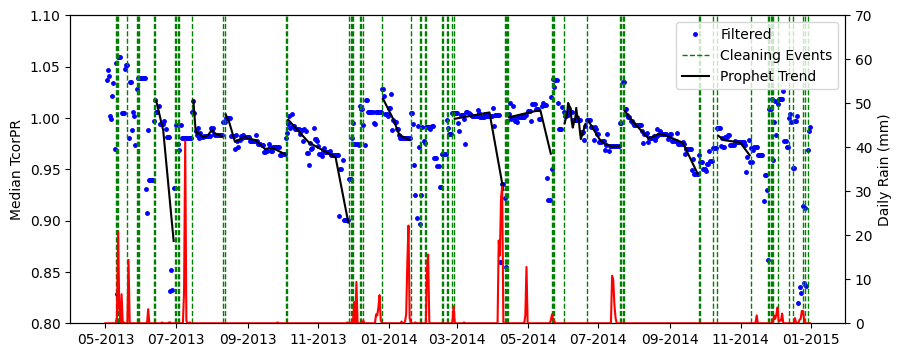

In [45]:

start_dates_after=[]
end_dates_after=[]
soiling_after=[]
sublist_collection = []

for i in range(1, len(cleaning_events)):
    start = cleaning_events[i - 1] + timedelta(days=1)
    end = cleaning_events[i] - timedelta(days=1)
    
    if (end - start).days >= 15:
        sub_df = hampel_pr[(hampel_pr.index >= start) & (hampel_pr.index <= end)]
        sublist_collection.append(sub_df)
        
        if len(sub_df) >= 15:
            trend = fbp(sub_df.index, sub_df.values)
            
            slopes = sub_df.diff().dropna()
            weights = len(sub_df)
            total_weighted_slope = 100.0*(slopes).sum() / weights
            start_dates_after.append(start)
            end_dates_after.append(end)
            soiling_after.append(total_weighted_slope)
            print(f"Start: {start}, End: {end}")
            print(total_weighted_slope/weights)

# Plotting code remains unchanged
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(hampel_pr.index, hampel_pr.values, 'o', color='blue', label='Filtered', markersize=2.5)

for event in cleaning_events:
    ax.axvline(x=event, color='green', linestyle='--', linewidth=1, label='Cleaning Events' if event == cleaning_events[0] else "")

for sublist in sublist_collection:
    trend = fbp(sublist.index, sublist.values)
    ax.plot(sublist.index, trend, color='black', label='Prophet Trend' if sublist is sublist_collection[0] else "")

ax2 = ax.twinx()
daily_max_rainfall = df.resample('D')['Weather_Daily_Rainfall'].max()
ax2.plot(daily_max_rainfall.index, daily_max_rainfall.values, color='red', label='Rainfall')
ax2.set_ylabel('Daily Rain (mm)')
ax2.set_ylim(0, 70)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.set_ylabel('Median TcorPR')
plt.xticks(rotation=90)
ax.set_ylim(0.8, 1.1)
ax.legend(loc='upper right')

plt.show()


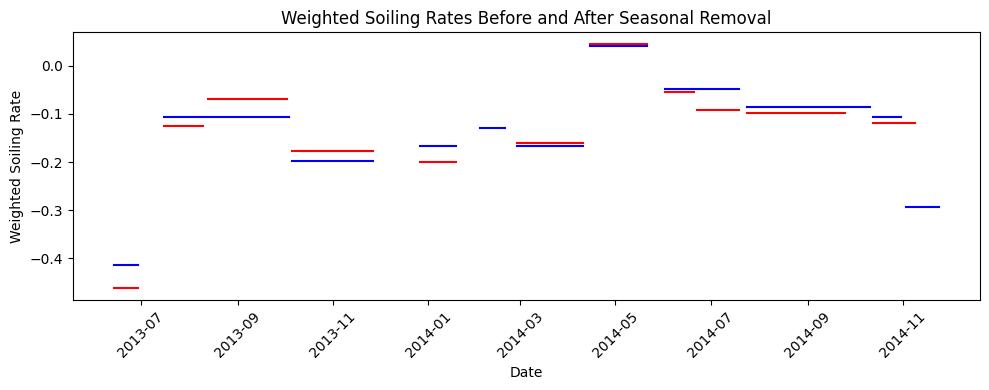

In [46]:

fig, ax = plt.subplots(figsize=(10, 4))

# Plotting after seasonal removal first
for i in range(len(start_dates_after)):
    ax.plot([start_dates_after[i], end_dates_after[i]], [soiling_after[i], soiling_after[i]], color='red')

# Plotting before seasonal removal second
for i in range(len(start_dates_before)):
    ax.plot([start_dates_before[i], end_dates_before[i]], [soiling_before[i], soiling_before[i]], color='blue')

# Adding labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Weighted Soiling Rate')
ax.set_title('Weighted Soiling Rates Before and After Seasonal Removal')


# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[-0.046916028702041035, -0.01900032826942566, 0.12975455959710236, -0.009733675034708206, -0.07040834707876506, 0.00669161296839571, 0.0038482815490315236, -0.004813376463286716, -0.005557986454746505, 0.008022838155412229, 0.17568627903185516]
[datetime.date(2013, 6, 14), datetime.date(2013, 7, 16), datetime.date(2013, 10, 6), datetime.date(2013, 12, 27), datetime.date(2014, 2, 3), datetime.date(2014, 2, 27), datetime.date(2014, 4, 15), datetime.date(2014, 6, 2), datetime.date(2014, 7, 24), datetime.date(2014, 10, 13), datetime.date(2014, 11, 3)]
[datetime.date(2013, 6, 29), datetime.date(2013, 10, 4), datetime.date(2013, 11, 27), datetime.date(2014, 1, 19), datetime.date(2014, 2, 19), datetime.date(2014, 4, 10), datetime.date(2014, 5, 21), datetime.date(2014, 7, 19), datetime.date(2014, 10, 11), datetime.date(2014, 10, 31), datetime.date(2014, 11, 24)]


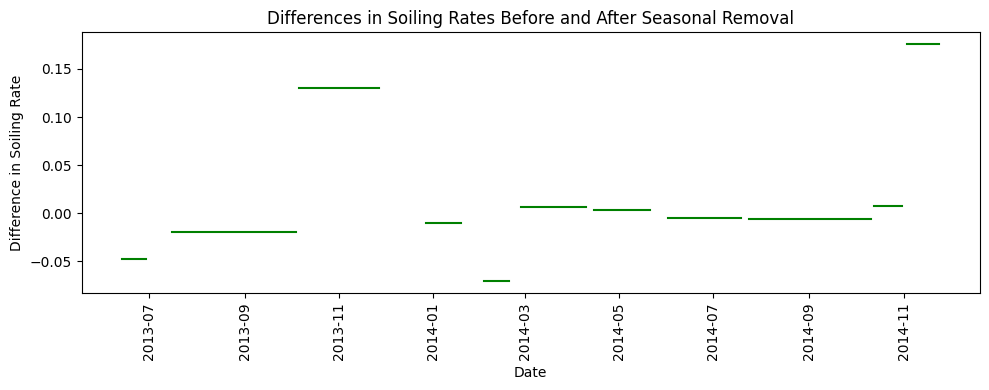

In [47]:
fig, ax = plt.subplots(figsize=(10, 4))
differences = [soiling_after[i] - soiling_before[i] for i in range(len(start_dates_before))]

print(differences)
print(start_dates_before)
print(end_dates_before)

# Plotting the differences
for i in range(len(start_dates_before)):
    ax.plot([start_dates_before[i], end_dates_before[i]], [differences[i], differences[i]], color='green')

# Adding labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Difference in Soiling Rate')
ax.set_title('Differences in Soiling Rates Before and After Seasonal Removal')
#ax.legend()

# Show plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()    

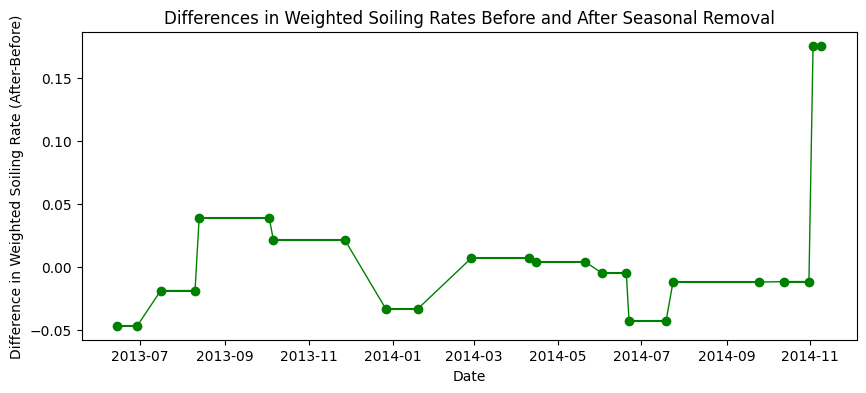

In [48]:


def get_overlap_and_diff(start1, end1, rate1, start2, end2, rate2):
    # Convert all dates to Timestamp to ensure compatibility
    start1, end1 = pd.Timestamp(start1), pd.Timestamp(end1)
    start2, end2 = pd.Timestamp(start2), pd.Timestamp(end2)
    
    overlap_start = max(start1, start2)
    overlap_end = min(end1, end2)
    if overlap_start < overlap_end:
        return overlap_start, overlap_end, rate2 - rate1
    else:
        return None, None, None

# Calculate differences
overlap_dates = []
soiling_diffs = []
for i in range(len(start_dates_before)):
    for j in range(len(start_dates_after)):
        start, end, diff = get_overlap_and_diff(start_dates_before[i], end_dates_before[i], soiling_before[i],
                                                start_dates_after[j], end_dates_after[j], soiling_after[j])
        if start and end:
            overlap_dates.append((start, end))
            soiling_diffs.append(diff)

# Plotting the differences
fig, ax = plt.subplots(figsize=(10, 4))

# Collecting all points for line connection
all_dates = []
all_diffs = []

for i in range(len(overlap_dates)):
    ax.plot([overlap_dates[i][0], overlap_dates[i][1]], [soiling_diffs[i], soiling_diffs[i]], color='green', marker='o')
    all_dates.extend([overlap_dates[i][0], overlap_dates[i][1]])
    all_diffs.extend([soiling_diffs[i], soiling_diffs[i]])

# Sorting the dates and differences
sorted_dates, sorted_diffs = zip(*sorted(zip(all_dates, all_diffs)))

# Connecting the dots with a line
ax.plot(sorted_dates, sorted_diffs, color='green', linestyle='-', linewidth=1)

# Adding labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Difference in Weighted Soiling Rate (After-Before)')
ax.set_title('Differences in Weighted Soiling Rates Before and After Seasonal Removal')

plt.show()
